# Final project for Computational Economics course

# *Identifying correlations of individual trading assets and building the RSI indicator*

### Import all necessary libraries for our project

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

from statsmodels.tsa.stattools import adfuller

### Functions for cross correlation analysis

In [2]:
def filt_by_date(ind, date):
    """
    Filter all tickers' data with general date
    
    Parameters:
    -----------
    ind: dict
        dict with tickers' info
    date: str or datetime object
        date to filter from
    
    Returns:
    -----------
    proxy: pd.DataFrame
        dataframe with filtered dates
    """
    proxy = ind.copy()
    for index, info in proxy.items():
        proxy[index] = info[info['<DATE>']>=date].set_index('<DATE>')
    return proxy

In [3]:
def drop_ticker(ind):
    """
    Drop <TICKER> column from tickers' data
    
    Parameters:
    -----------
    ind: dict
        dict with tickers' info
        
    Returns:
    -----------
    proxy: pd.DataFrame
        dataframe without <TICKER> column
    """
    
    proxy = ind.copy()
    for index, info in ind.items():
        proxy[index] = info.drop(columns=['<TICKER>'])
    return proxy

In [4]:
def dickey_fuller_test(series):
    """
    Conduct Dickey-Fuller with specified print output
    
    Parameters:
    -----------
    series: pd.Series
        series to conduct test on
    
    Returns:
    -----------
    bool
        True or False depending on time series stationarity
    """
    try:
        test = adfuller(series.dropna())
    except:
        test = adfuller(series)
    print(f"Dickey-Fuller test for {series.name}")
    print("------------------------------")
    print('adf:', round(test[0], 3))
    print('p-value:', round(test[1], 3))
    for percent in test[4]:
        print(f"{percent}: {round(test[4][percent], 3)}")
    if test[0] > test[4]['5%']:
        print('There are unit roots, the series is not stationary')
        return False
    else:
        print('There are no unit roots, the series is stationary')
        return True

In [5]:
def crosscorr(datax, datay, lag=0):
    """
    Lag-N cross correlation. 
    
    Parameters:
    ----------
    lag : int, default 0
        lag value to use in correlation
        
    datax, datay : pandas.Series objects of equal length
    Returns
    ----------
    crosscorr : float
    """
    return datax.corr(datay.shift(lag))

In [6]:
def check_stationarity(ind):
    """
    Check stationarity of time series
    
    Parameters:
    -----------
    ind: dict
        dict with tickers' data
    
    Returns:
    -----------
    stationarity: pd.DataFrame
    """
    stationarity = {}
    for index, info in ind.items():
        print("============================================")
        print(f'Testing {index} on stationarity')
        print()
        stationarity_values = []
        for column in info.columns:
            series = info[column]
            sta_value = dickey_fuller_test(series)
            stationarity_values.append(sta_value)
            print()

        stationarity[index] = stationarity_values
        print()
    return stationarity

In [7]:
def get_table(stationarity):
    """
    Get table from stationarity dict info
    
    Parameters:
    -----------
    stationarity: dict
        dict with stationarity info
        
    Returns:
    pd.DataFrame
    """
    return pd.DataFrame(stationarity, index=['<OPEN>', '<HIGH>', '<LOW>', '<CLOSE>', '<VOL>']).T

In [8]:
def detrended_stationarity(ind, lag):
    """
    Check stationarity on detrended tickers' data
    
    Parameters:
    -----------
    ind: dict
        dict with tickers' info
    lag: int
        value of lag for detrending
    
    Returns:
    new_stationarity: dict
        dict with detrended stationarity info
    
    """
    new_stationarity = {}
    ind_new = ind.copy()
    for index, info in ind_new.items():
        print("================================================================")
        print(f'Detrending time series of {index} to follow stationarity')
        print()
        stationarity_values = []
        for column in info.columns:
            series = info[column]
            sta_value = dickey_fuller_test(series)
            
            if sta_value:
                stationarity_values.append(sta_value)
                print(f'Time series {column} is stationary, no need to detrend')
            else:
                series_diff = series.diff(periods=lag)
                sta_value = dickey_fuller_test(series_diff)
                stationarity_values.append(sta_value)
                print(f'Time series {column} is not stationary. Detrending performed')
            print()

        new_stationarity[index] = stationarity_values
        print()
    return new_stationarity

In [9]:
def get_corrs(target, ind, lags, rnd=0):
    """
    Get correlations of target ticker with other tickers in ind
    
    Parameters:
    -----------
    target: str
        string with the name of ticker to calc correlations
    ind: dict
        dict with tickers' info
    lags: Iterable
        Iterable object containing the lags to use for correlations
    rnd: int
        number of decimals to round correlation
    
    Returns:
    corrs: dict
        dict with correlations of target to other tickers
    
    """
    corrs = {}
    results = []
    lags_cnt = len(lags)
    for index, info in ind.items():
        
        if index == target:
            continue
        corrs[index] = {}
        for column in info.columns:
            lagged_corr = []
            for lag in lags:
                ser = crosscorr(ind[target][column], ind[index][column], lag)
                ser = round(ser, rnd)
                lagged_corr.append(ser)
            corrs[index][column] = lagged_corr
    return corrs

In [10]:
def get_table_corrs(target, corrs, lags):
    """
    Make a pretty table with all correlations to specific target
    
    Parameters:
    -----------
    target: str
        string with the name of ticker used to count correlations
    corrs: dict
        dict with correlations of target to other tickers
    lags: Iterable
        Iterable object containing the lags used in correlations
    
    
    Returns:
    df: pd.DataFrame
        dataframe containing correlation to all other tickers
    
    """
    columns = ['<OPEN>', '<HIGH>', '<LOW>', '<CLOSE>', '<VOL>']
    milevel1 = [f'Cross correlation of {target}(t+k) with other tickers' for i in range(5*len(lags))]
    milevel2 = [column.strip('<>') for column in columns for i in range(len(lags))]
    milevel3 = [[i for i in lags] for j in range(len(columns))]
    milevel3 = [item for sublist in milevel3 for item in sublist]
    
    col_names = list(zip(milevel1, milevel2, milevel3))
    
    df = pd.DataFrame(corrs).explode(list(corrs.keys())).T
    
    df.columns = pd.MultiIndex.from_tuples(col_names)
    df.index.name = 'Ticker'
    return df

In [11]:
def detrending(ind):
    """
    Perform detrending on tickers' data
    
    Parameters:
    -----------
    ind: dict
        dict with tickers' data
        
    Returns:
    ind_new: dict
        dict with detrended tickers' data
    
    """
    ind_new = ind.copy()
    for index, info in ind_new.items():
        for column in info.columns:
            ind_new[index][column] = ind_new[index][column].diff(periods=1)
        
        ind_new[index] = ind_new[index].dropna()
    
    return ind_new

In [12]:
def get_all_corrs(ind_detrended, lags, rnd=3):
    """
    Count all possible cross correlation and get it in the final dict
    
    Parameters:
    -----------
    ind_detrended: dict
        dict with detrended tickers' data
    lags: Iterable
        Iterable object containing the lags used in correlations
    rnd: int
        number of decimals to round correlation
        
    Returns:
    new_stationarity: dict
        dict with detrended stationarity info
    
    """
    all_corrs = {}
    for ticker in list(ind_detrended.keys()):
        corrs = get_corrs(ticker, ind_detrended, lags, rnd=rnd)
        table = get_table_corrs(ticker, corrs, lags)
        all_corrs[ticker] = table
    return all_corrs

In [13]:
def stylize_table(df, rnd):
    """
    Stylize given dataframe for better interpretation
    
    Parameters:
    -----------
    df: pd.DataFrame
        dataframe to style
    rnd: ind
        number of decimals to round values
        
    Returns:
    df_styled: pandas.io.formats.style.Styler
        styled dataframe
    
    """

    df_styled = df.style \
        .background_gradient(cmap='coolwarm', vmin=-1, vmax=1, subset=df.columns) \
        .set_table_styles([dict(selector = 'th', props=[('text-align', 'center')])]).format(f'{{:.{rnd}f}}')
    return df_styled

## Function for calculation RSI

In [14]:
def calc_rsi(ticker, ind):
        """
        Calculate relative strength index for specific ticker
        
        Parameters:
        -----------
        ticker: str
            ticker to calculate rsi for
        ind: dict
            dict with tickers' data

        Returns:
        chart 
        
        """
        df = ind[ticker].copy()

        #Firstly, we need to calculate the difference between a day and a day before that day 
        difference = df['<CLOSE>'].diff(1)
        difference.dropna(inplace=True)

        positive = difference.copy()
        negative = difference.copy()

        #rid of negative numbers in positive column and rid of positive numbers in negative column
        positive[positive < 0] = 0
        negative[negative > 0] = 0

        #parameter for time period we are looking at. It could be any number. 
        #The less weeks we take the more 'compressed' graph we will receive/
        week = 14

        #some varibles that need for the future calculations
        average_gain = positive.rolling(window=week).mean()
        average_loss = abs(negative.rolling(window=week).mean())

        #relative strength is the ratio of the dynamics of the stock price to the market average result
        relative_strength = average_gain/average_loss
        RSI = 100.0 - (100.0 / (1.0 + relative_strength))

        #creating a dataframe with obtained information
        combined = pd.DataFrame()
        combined['<DATE>'] = df['<DATE>']
        combined['Close'] = df['<CLOSE>']
        combined['RSI'] = RSI

        #creating a plot
        plt.figure(figsize=(12,8))
        ax1 = plt.subplot(211)
        ax1.plot(combined['<DATE>'], combined['Close'], color='gray')
        ax1.set_title(ticker, color='black')

        ax2 = plt.subplot(212, sharex = ax1)
        ax2.plot(combined['<DATE>'], combined['RSI'], color='gray')
        ax2.axhline(0, linestyle = '--', alpha = 0.5, color='lightgray')
        ax2.axhline(10, linestyle = '--', alpha = 0.5, color='lightgray')
        ax2.axhline(20, linestyle = '--', alpha = 0.5, color='lightgray')
        ax2.axhline(30, linestyle = '--', alpha = 0.5, color='lightgray')
        ax2.axhline(70, linestyle = '--', alpha = 0.5, color='lightgray')
        ax2.axhline(80, linestyle = '--', alpha = 0.5, color='lightgray')
        ax2.axhline(90, linestyle = '--', alpha = 0.5, color='lightgray')
        ax2.axhline(100, linestyle = '--', alpha = 0.5, color='lightgray')

        ax2.set_title('RSI indicator')
        ax2.grid(False)

## Main analysis

### Import all neccesary data from local computer

We have chosen these tickers because we wanted to know correlation between:
1. Russian companies
2. Russian companies and moscow stock exchange index
3. Russian companies and USA companies in the same sphere (oil, gas, financial sector)
4. Russian companies and price for commodities (gas, oil)
5. Russian companies and ruble exchange rate

In [15]:
moex = pd.read_excel('MOEX.xlsx')
sber = pd.read_excel('SBER.xlsx')
gazp = pd.read_excel('GAZP.xlsx')
rosn = pd.read_excel('ROSN.xlsx')
cvx = pd.read_excel('CVX.xlsx')
gas = pd.read_excel('GAS.xlsx')
usdrub = pd.read_excel('USDRUB.xlsx')
brent = pd.read_excel('BRENT.xlsx')
jpm = pd.read_excel('JPM.xlsx')
swn = pd.read_excel('SWN.xlsx')
    

### Set filter date border

In [16]:
start_date = moex.iloc[0, 1]

### Set dict, containing the information about tickers

In [17]:
ind = {
    'MOEX': moex,
    'SBER': sber,
    'GAZP': gazp,
    'ROSN': rosn,
    'CVX': cvx,
    'GAS': gas,
    'USDRUB': usdrub,
    'BRENT': brent,
    'JPM': jpm,
    'SWN': swn
}


### Filter ticker's data by *start_date*

In [18]:
ind_filt = filt_by_date(ind, start_date)

### Drop an unnecessary column to make the data look more accurate

In [19]:
ind_d = drop_ticker(ind_filt)

### Conduction Dickey-Fuller test for checking for stationarity

### We need stationarity time series to make our cross correlations precise

In [20]:
init_stationarity = check_stationarity(ind_d)

Testing MOEX on stationarity

Dickey-Fuller test for <OPEN>
------------------------------
adf: -1.634
p-value: 0.465
1%: -3.443
5%: -2.867
10%: -2.57
There are unit roots, the series is not stationary

Dickey-Fuller test for <HIGH>
------------------------------
adf: -1.636
p-value: 0.464
1%: -3.443
5%: -2.867
10%: -2.57
There are unit roots, the series is not stationary

Dickey-Fuller test for <LOW>
------------------------------
adf: -1.695
p-value: 0.434
1%: -3.444
5%: -2.867
10%: -2.57
There are unit roots, the series is not stationary

Dickey-Fuller test for <CLOSE>
------------------------------
adf: -1.71
p-value: 0.426
1%: -3.443
5%: -2.867
10%: -2.57
There are unit roots, the series is not stationary

Dickey-Fuller test for <VOL>
------------------------------
adf: -4.649
p-value: 0.0
1%: -3.444
5%: -2.867
10%: -2.57
There are no unit roots, the series is stationary


Testing SBER on stationarity

Dickey-Fuller test for <OPEN>
------------------------------
adf: -1.394
p-valu

1%: -3.443
5%: -2.867
10%: -2.57
There are no unit roots, the series is stationary


Testing SWN on stationarity

Dickey-Fuller test for <OPEN>
------------------------------
adf: -4.054
p-value: 0.001
1%: -3.449
5%: -2.87
10%: -2.571
There are no unit roots, the series is stationary

Dickey-Fuller test for <HIGH>
------------------------------
adf: -3.88
p-value: 0.002
1%: -3.448
5%: -2.87
10%: -2.571
There are no unit roots, the series is stationary

Dickey-Fuller test for <LOW>
------------------------------
adf: -4.39
p-value: 0.0
1%: -3.449
5%: -2.87
10%: -2.571
There are no unit roots, the series is stationary

Dickey-Fuller test for <CLOSE>
------------------------------
adf: -4.955
p-value: 0.0
1%: -3.449
5%: -2.87
10%: -2.571
There are no unit roots, the series is stationary

Dickey-Fuller test for <VOL>
------------------------------
adf: -1.735
p-value: 0.413
1%: -3.449
5%: -2.87
10%: -2.571
There are unit roots, the series is not stationary




### Check initial stationarity

### As we can observe, trade volume in most cases are stationary. It may be due to constant trading volumes daily. People every day buy and sell stock in approximately same volume. Also, it is interesting why oil is not stationary in all cases. We assume that SouthwesternEnergy company is stationary due to low popularity of this stock. But it's volume can be different due to macroeconomics and politics factors. Situation with JPMorgan other-vice.

In [21]:
get_table(init_stationarity)

,<OPEN>,<HIGH>,<LOW>,<CLOSE>,<VOL>
MOEX,False,False,False,False,True
SBER,False,False,False,False,True
GAZP,False,False,False,False,True
ROSN,False,False,False,False,True
CVX,False,False,False,False,True
GAS,False,False,False,False,True
USDRUB,True,True,False,True,False
BRENT,False,False,False,False,False
JPM,False,False,False,False,True
SWN,True,True,True,True,False


### Looking for stationarity after detrending

In [22]:
final_stationarity = detrended_stationarity(ind_d, lag=1)

Detrending time series of MOEX to follow stationarity

Dickey-Fuller test for <OPEN>
------------------------------
adf: -1.634
p-value: 0.465
1%: -3.443
5%: -2.867
10%: -2.57
There are unit roots, the series is not stationary
Dickey-Fuller test for <OPEN>
------------------------------
adf: -22.421
p-value: 0.0
1%: -3.443
5%: -2.867
10%: -2.57
There are no unit roots, the series is stationary
Time series <OPEN> is not stationary. Detrending performed

Dickey-Fuller test for <HIGH>
------------------------------
adf: -1.636
p-value: 0.464
1%: -3.443
5%: -2.867
10%: -2.57
There are unit roots, the series is not stationary
Dickey-Fuller test for <HIGH>
------------------------------
adf: -16.088
p-value: 0.0
1%: -3.443
5%: -2.867
10%: -2.57
There are no unit roots, the series is stationary
Time series <HIGH> is not stationary. Detrending performed

Dickey-Fuller test for <LOW>
------------------------------
adf: -1.695
p-value: 0.434
1%: -3.444
5%: -2.867
10%: -2.57
There are unit roots,

Dickey-Fuller test for <LOW>
------------------------------
adf: -1.669
p-value: 0.447
1%: -3.444
5%: -2.867
10%: -2.57
There are unit roots, the series is not stationary
Dickey-Fuller test for <LOW>
------------------------------
adf: -10.807
p-value: 0.0
1%: -3.444
5%: -2.867
10%: -2.57
There are no unit roots, the series is stationary
Time series <LOW> is not stationary. Detrending performed

Dickey-Fuller test for <CLOSE>
------------------------------
adf: -1.566
p-value: 0.501
1%: -3.443
5%: -2.867
10%: -2.57
There are unit roots, the series is not stationary
Dickey-Fuller test for <CLOSE>
------------------------------
adf: -5.894
p-value: 0.0
1%: -3.444
5%: -2.867
10%: -2.57
There are no unit roots, the series is stationary
Time series <CLOSE> is not stationary. Detrending performed

Dickey-Fuller test for <VOL>
------------------------------
adf: -5.087
p-value: 0.0
1%: -3.443
5%: -2.867
10%: -2.57
There are no unit roots, the series is stationary
Time series <VOL> is stationa

Time series <CLOSE> is not stationary. Detrending performed

Dickey-Fuller test for <VOL>
------------------------------
adf: -5.449
p-value: 0.0
1%: -3.443
5%: -2.867
10%: -2.57
There are no unit roots, the series is stationary
Time series <VOL> is stationary, no need to detrend


Detrending time series of SWN to follow stationarity

Dickey-Fuller test for <OPEN>
------------------------------
adf: -4.054
p-value: 0.001
1%: -3.449
5%: -2.87
10%: -2.571
There are no unit roots, the series is stationary
Time series <OPEN> is stationary, no need to detrend

Dickey-Fuller test for <HIGH>
------------------------------
adf: -3.88
p-value: 0.002
1%: -3.448
5%: -2.87
10%: -2.571
There are no unit roots, the series is stationary
Time series <HIGH> is stationary, no need to detrend

Dickey-Fuller test for <LOW>
------------------------------
adf: -4.39
p-value: 0.0
1%: -3.449
5%: -2.87
10%: -2.571
There are no unit roots, the series is stationary
Time series <LOW> is stationary, no need to det

### Now we can assure that our detrending idea with specified lag might be stationary

In [23]:
get_table(final_stationarity)

,<OPEN>,<HIGH>,<LOW>,<CLOSE>,<VOL>
MOEX,True,True,True,True,True
SBER,True,True,True,True,True
GAZP,True,True,True,True,True
ROSN,True,True,True,True,True
CVX,True,True,True,True,True
GAS,True,True,True,True,True
USDRUB,True,True,True,True,True
BRENT,True,True,True,True,True
JPM,True,True,True,True,True
SWN,True,True,True,True,True


### Detrending (differencing) ticker's time series

In [24]:
ind_detrended = detrending(ind_d)

### Get all tickers' correlation to other tickers



 ***all_cores*** is a dict, where the key is a ticker we cross correlate with other tickers


In [25]:
all_corrs = get_all_corrs(ind_detrended, range(-1, 2), rnd=3)

### Example of accessing 'ROSN' ticker (any of preloaded tickers might be used as a key):


In [26]:
all_corrs['ROSN']

Cross correlation of ROSN(t+k) with other tickers                       \
                                                    OPEN                 HIGH   
                                                      -1      0      1     -1   
Ticker                                                                          
MOEX                                               0.049  0.488   0.05  0.126   
SBER                                                0.09  0.591  0.025  0.194   
GAZP                                               0.144  0.482  0.024  0.133   
CVX                                                0.036  0.346  0.013   0.09   
GAS                                               -0.013   0.01  0.123 -0.002   
USDRUB                                             0.021 -0.063 -0.127 -0.091   
BRENT                                              0.019  0.268  0.278  0.059   
JPM                                                0.095  0.243  0.146  0.161   
SWN                                                0.013  0.138  0.016  0.015   

                                                                              \
                        LOW                CLOSE                  VOL          
            0      1     -1      0      1     -1      0      1     -1      0   
Ticker                                                                         
MOEX    0.392  0.055  -0.08  0.677 -0.074  0.057   0.48  0.001 -0.282  0.503   
SBER    0.554 -0.021 -0.064  0.752 -0.081  0.084  0.584 -0.013 -0.304  0.734   
GAZP    0.364  0.121   -0.2  0.734 -0.093   0.07   0.52  0.013 -0.275  0.683   
CVX     0.295   0.16  0.033  0.311  0.052  0.017  0.227  0.048 -0.041  0.261   
GAS    -0.024  0.115  0.047  0.062 -0.006 -0.021  0.022   0.06 -0.116  0.056   
USDRUB -0.097  0.027 -0.351 -0.244 -0.115 -0.446 -0.283 -0.053 -0.021  0.194   
BRENT   0.148   0.37  0.044  0.218  0.057 -0.178  0.194  0.172  -0.06  0.134   
JPM     0.287  0.158  0.118  0.383  0.078  0.268  0.239  0.113 -0.046  0.135   
SWN     0.073  0.049  0.021  0.127  0.024  0.035  0.114   0.01 -0.043   0.02   

               
               
            1  
Ticker         
MOEX   -0.036  
SBER    -0.16  
GAZP   -0.201  
CVX      0.13  
GAS     0.056  
USDRUB -0.074  
BRENT     0.1  
JPM     0.084  
SWN     0.043

### Now let consider all correlation with, for example, GAZPROM

As we can observe, GAZPROM has high correlation in all caterogies(high,low, volume, etc.) with Russian companies and index MOEX due to huge impact of internal and external situation. It is no surprise that Gazprom has no correlation with gas price because it is world gas price (not europe gas price). Our lag equals 1 week. As we can see, today's ruble appreciation negatively correlates with the price of Gazprom in a week and this is understandable, because Gazprom is an exporting company. The most interesting aspect of our correlation table is that Gazprom is not correlated with SouthWesternEnergy(GAS USA company), but correlation with JPM lowest prices is high and positive. We assume, that it connected with global crises and recessions.

In [27]:
stylize_table(all_corrs['GAZP'], rnd=3)

### Let's consider BRENT oil

Brent crude oil has a strong correlation with Chevron stock price and weak correlation with Rosneft because first company extracts and processes this oil while second one offers urals brand oil. Also, Brent oil doesn’t have correlation with Russian stocks at all. Also, there is no correlation with rubble exchange rate. Weak correlation is observed with JPMorgan and more strong with SouthwesternEnergy

In [28]:
stylize_table(all_corrs['BRENT'], rnd=3)

### Check for RSI of GAZPROM

RSI is good working on historical data (2009,2011,2021 years), but today value does not contain much information.
The interpretation of RSI indicator is following = overbought level of the asset is above the value of 70, oversold — below 30.

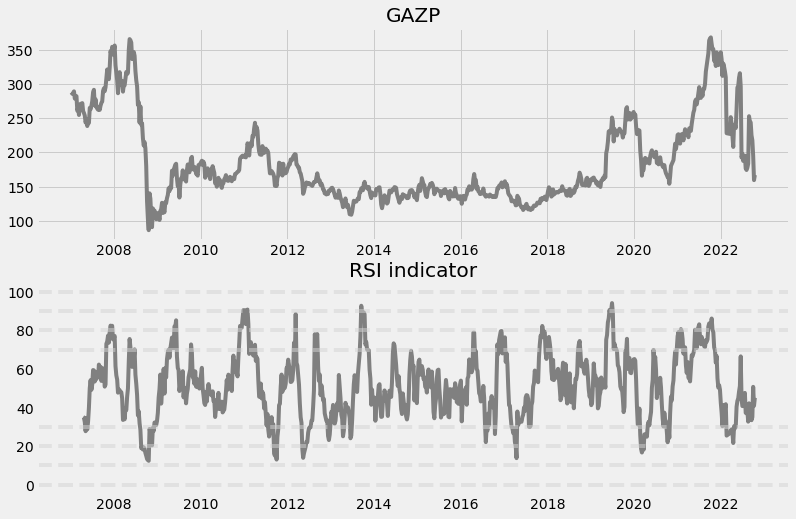

In [29]:
calc_rsi('GAZP', ind)

### After all, there are plenty of opportunities to use acquired cross correlations and RSI for different interpretations.

### The following baseline code in this .ipynb file is scalable. If you want check any other tickers, It is only required to add new tickers with the same columns, that are used in the code, in the *ind* dict

### Thank you for reviewing!

---